# Test Variational Inference algorithms for Wold processes

In this notebook, we test the various variational inference (VI) algorithms implemented for the multivariate Wold process. Namely:

* `WoldModelVariational`: VI with parameters $\alpha$ and $\beta$

with the **new updates** involving solving a set of 2d^2 1-dimensional equations.

---

Load extensions for debugging

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

Import the libraries of interest for this notebook

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import itertools
import torch
import numpy as np

# Set numpy print format
np.set_printoptions(precision=2, floatmode='fixed', sign=' ')

import tsvar

---

## Generate small toy example dataset


In [ ]:
# Define random parameters
dim = 2  # Dimensionality of the process
max_jumps=5e3 * dim  # Number of events

mu = torch.tensor([0.3, 0.1])
beta = torch.tensor([
    [1.0, 0.2],
    [0.5, 0.1]
])
# Use the same constraint as GrangerBusca to allow fair comparison
alpha = torch.tensor([
    [0.7, 0.3],
    [0.0, 1.0]
])

In [10]:
from experiments_utils import generate_parameters

dim = 10
max_jumps=5e3 * dim

param_dict = generate_parameters(dim=dim)

mu = torch.tensor(param_dict['baseline'])
beta = torch.tensor(param_dict['beta'])
alpha = torch.tensor(param_dict['adjacency'])

In [11]:
a_pos = alpha.numpy().flatten()
a_pos = a_pos[a_pos > 0.0]
pd.Series(a_pos).describe()

count    45.000000
mean      0.121184
std       0.040510
min       0.050300
25%       0.091900
50%       0.125500
75%       0.154800
max       0.192600
dtype: float64

In [12]:
coeffs_true = torch.cat((mu, beta.flatten(), alpha.flatten())).numpy()
print('  - Simulate lots of data...')
# Simulate lots of data
wold_sim = tsvar.simulate.MultivariateWoldSimulator(
    mu_a=mu, alpha_ba=alpha, beta_ba=beta)
events = wold_sim.simulate(max_jumps=max_jumps, seed=None)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]
end_time = max(map(max, events))
print((f"    - Simulated {sum(map(len, events)):,d} events "
       f"with end time: {end_time}"))
print("    - Events:")
for i, events_i in enumerate(events):
    print(f"      - dim {i:>2d} ({len(events_i):>5d} events):", events_i.numpy())

  - Simulate lots of data...
    - Simulated 50,000 events with end time: 44819.15234375
    - Events:
      - dim  0 ( 6880 events): [    51.57     52.64     59.74 ...  44809.94  44811.27  44813.16]
      - dim  1 ( 5432 events): [     5.55     25.63     54.25 ...  44787.03  44801.16  44816.68]
      - dim  2 ( 5140 events): [     7.26     55.55     56.56 ...  44807.54  44814.33  44816.94]
      - dim  3 ( 4990 events): [    32.89     37.94     75.25 ...  44807.27  44812.27  44814.30]
      - dim  4 ( 6279 events): [    63.92     71.81     80.09 ...  44813.44  44817.26  44817.80]
      - dim  5 ( 5759 events): [    38.43     44.97     49.16 ...  44811.77  44816.44  44816.57]
      - dim  6 ( 6381 events): [    43.13     49.94     52.60 ...  44794.91  44804.95  44819.15]
      - dim  7 ( 2080 events): [   156.41    178.90    187.78 ...  44663.17  44769.36  44802.71]
      - dim  8 ( 4005 events): [   629.86    630.39    634.90 ...  44800.69  44808.86  44809.29]
      - dim  9 ( 3054 ev

---

## Test Mean-Field VI with Variable $\{\beta\}$s using `WoldModelVariational`

Define the parameters of the prior.

In [13]:
# Set priors
# prior: Alpha
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 31.0 * np.ones((dim, dim))
br_pr = 40.0 * np.ones((dim, dim))
#bs_pr = 2.1 * np.ones((dim, dim))
#br_pr = (beta.numpy() + 1) * (bs_pr - 1)

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('BETA:')
print('mean')
print(br_pr / (bs_pr - 1))
print('variance')
print(br_pr**2 / ((bs_pr - 1)**2 * (bs_pr - 2)))

BETA:
mean
[[ 1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00]
 [ 1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00]
 [ 1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00]
 [ 1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00]
 [ 1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00]
 [ 1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00]
 [ 1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00]
 [ 1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00]
 [ 1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00]
 [ 1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00  1.00]]
variance
[[ 0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03]
 [ 0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03]
 [ 0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03]
 [ 0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03]
 [ 0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03]
 [ 0.03  0.03  0.03  0.03  0.03  0

Fit the model.

In [14]:
# Set callback to monitor progress
coeffs_start = alpha.numpy().flatten().copy()
callback = tsvar.utils.callbacks.LearnerCallbackMLE(x0=coeffs_start,
                                                    print_every=10,
                                                    coeffs_true=alpha.numpy().flatten(),
                                                    acc_thresh=0.05,
                                                    dim=dim)

# Set model & observations
model = tsvar.models.WoldModelVariational(verbose=True)
model.observe(events)

import time
st = time.time()

# Fit model
model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=1000, tol=1e-4, callback=callback)

print()
print(time.time() - st)

iter:   280 | dx: +9.9342e-05 | acc: 0.93 | f1-score: 0.92 | relerr: 0.24 | time/it: 7.12e-02     

21.344337940216064


Extract the runtime

In [15]:
hist = callback.to_dict()

np.mean(hist['time'][1:]) * hist['iter'][-1]

21.079455658241557

---

Show results

In [16]:
alpha_hat_mean = np.round(model._as_po / model._ar_po, 2)

baseline_hat = alpha_hat_mean[0,:]
print('Baseline:')
print('---------')
print('Ground truth:')
print(mu.numpy())
print('Estimated:')
print(baseline_hat)
print()

adjacency_hat = alpha_hat_mean[1:,:]
print('Adjacency:')
print('---------')
print('Ground truth:')
print(alpha.numpy())
print('Estimated:')
print(adjacency_hat)
print()

beta_hat = np.round(model._br_po / (model._bs_po - 1), 2)
print('Beta:')
print('-----')
print('Ground truth:')
print(beta.numpy() * np.ones((dim, dim)) + 1)
print('Estimated:')
print(beta_hat)
print(pd.Series(beta_hat.flatten()).describe())

Baseline:
---------
Ground truth:
[ 0.01  0.04  0.03  0.03  0.03  0.03  0.02  0.01  0.00  0.03]
Estimated:
[ 0.01  0.04  0.03  0.02  0.02  0.02  0.02  0.00  0.00  0.03]

Adjacency:
---------
Ground truth:
[[ 0.14  0.00  0.10  0.00  0.16  0.09  0.11  0.13  0.14  0.00]
 [ 0.00  0.00  0.13  0.13  0.14  0.16  0.00  0.00  0.00  0.13]
 [ 0.00  0.00  0.00  0.00  0.00  0.13  0.00  0.05  0.00  0.00]
 [ 0.19  0.10  0.05  0.00  0.00  0.08  0.18  0.00  0.00  0.05]
 [ 0.00  0.16  0.16  0.07  0.19  0.00  0.11  0.00  0.12  0.00]
 [ 0.12  0.00  0.00  0.15  0.07  0.00  0.00  0.00  0.15  0.00]
 [ 0.08  0.10  0.00  0.07  0.00  0.00  0.06  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.06  0.17  0.00  0.00  0.12]
 [ 0.18  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.13  0.00]
 [ 0.17  0.12  0.09  0.00  0.00  0.15  0.16  0.08  0.00  0.00]]
Estimated:
[[ 0.15  0.00  0.06  0.01  0.14  0.06  0.08  0.10  0.10  0.00]
 [ 0.01  0.00  0.08  0.09  0.14  0.13  0.00  0.01  0.00  0.11]
 [ 0.00  0.00  0.00  0.00  

---

Debug optimization of $x_0$ and $x_n$

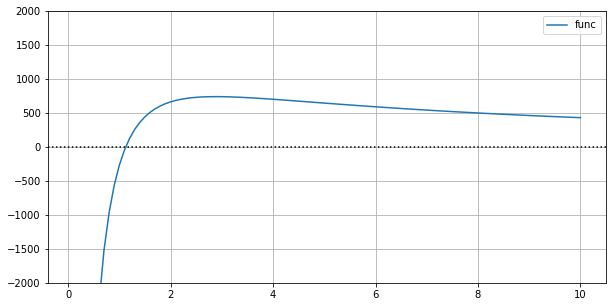

In [36]:
kwargs = {'bs_pr': model._bs_pr, 'br_pr': model._br_pr, 
          'as_po': model._as_po, 'ar_po': model._ar_po, 
          'zp_po': model._zp_po, 'dts': model.dt_ik, 
          'delta': model.delta_ikj, 'valid_mask': model.valid_mask_ikj}

x = np.linspace(0.1, 10.0, 100)
j=0
i=1
n=0
y = [tsvar.models._wold_var.func(e, j=j, i=i, n=n, **kwargs) for e in x]
dy = [tsvar.models._wold_var.fprime(e, j=j, i=i, n=n, **kwargs) for e in x]
ddy = [tsvar.models._wold_var.fprime2(e, j=j, i=i, n=n, **kwargs) for e in x]

plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(x, y, c='C0', label='func')
#plt.plot(x, dy, c='C1', label="fprime")
#plt.plot(x, ddy, c='C2', label='fprime2')
plt.legend()
plt.ylim(-2000.0, 2000.0)
plt.axhline(0.0, c='k', ls=':')

---

## Plot exact and approximated densities of $\beta$

In [408]:
# Set model & add observations
model = tsvar.models.WoldModelVariational(verbose=True)
model.observe(events)

beta_range = np.linspace(0.01, 5.0, 110)

i = 0
j = 0

true_post = tsvar.models._wold_var.exact_beta_density(
    beta_range=beta_range,
    bs_pr=10.0,  # beta shape
    br_pr=10.0,  # beta rate
    as_po=0.2,  # alpha shape
    ar_po=1.0,  # alpha rate
    zp_po=0.33 * np.ones(model.n_jumps[i]),  # Uniform Z p=0.33 for all
    dts=model.dt_ik[i],
    delta=model.delta_ikj[i][:, j+1],
    valid_mask=model.valid_mask_ikj[i][:,j+1])

true_post

array([ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.01,  0.02,  0.03,  0.04,  0.05,  0.05,  0.06,  0.06,  0.06,  0.06,  0.06,  0.05,  0.05,  0.04,  0.04,  0.04,  0.03,  0.03,  0.03,  0.02,  0.02,  0.02,  0.02,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
        0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00])

In [409]:
approx_post = tsvar.models._wold_var.approx_beta_density(
    beta_range=beta_range, 
    j=j, i=i, 
    x0=1.0, xn=1.0, n=2, 
    
    as_po=0.2 * np.ones((3, 2)), 
    ar_po=1.0 * np.ones((3, 2)), 
    
    zp_po=[0.33 * np.ones((model.n_jumps[i], 3))], 
    
    bs_pr=10.0 * np.ones((2, 2)), 
    br_pr=10.0 * np.ones((2, 2)), 
    
    dt_ik=model.dt_ik, 
    delta_ikj=model.delta_ikj, 
    valid_mask_ikj=model.valid_mask_ikj)

10.000000099000001 10.000000100000001


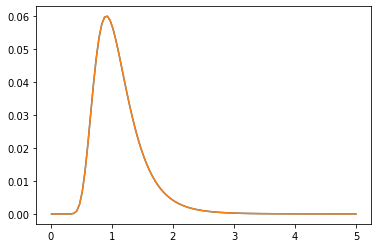

In [410]:
plt.plot(beta_range, true_post)
plt.plot(beta_range, approx_post)